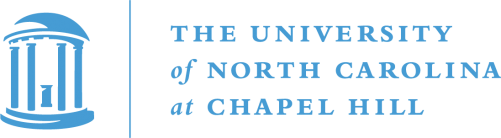


# Notebook 19
**Course:** *Econ 590, Computational Methods for Economists*, [University of North Carolina at Chapel Hill](https://econ.unc.edu/), Spring 2025  
**Instructor:** [Marlon Azinovic-Yang](https://sites.google.com/view/marlonazinovic/home)  
**Contact:** marlonay@unc.edu  

## Content
In this notebook we will use [Deep Equilibrium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575) to compute the equilibrium in a stochastic overlapping generations model. We will implement it using the `jax` library. For more example code, see [here](https://sites.google.com/view/marlonazinovic/teaching-and-service?authuser=0). For extensions to the methodology, see [Azinovic and Zemlicka (2024)](https://drive.google.com/file/d/1Kff3ZPLpCMq4W7p5uGi0NmhepXZ8wRpp/view).

## The Model
Time is discrete and infinite: $t = 0, 1, 2, \dots$. Each period, one of four stochastic shocks $z_t \in \{0, 1, 2, 3\}$ realizes. The shock $z_t$ evolves according to a first order time homogeneous Markov chain with transition matrix $\Pi$. The stochastic shock determines the total factor productivity $A_t$ and the depreciation rate of capital $\delta_t$.

We model 7 age groups in an overlapping generations framework. Let $k_t^a$ denote the capital held by age-group $a$ in the beginning of period $t$. Aggregate capital is given by $K_t = \sum_{a = 0}^6 k_t^a$ and aggregate labor supply is given by $L = \sum_{a = 0}^6 l^a = 1$. We assume that age-group $a$ inealstically supplies $l^a$ units of labor.

A representative firm produces output $Y_t = A_t K_t^\alpha L^{1 - \alpha}$ from capital and labor. The firm rents the capital from households at rental rate $r_t^K = \alpha A_t K_t^{\alpha-1} L^{1 - \alpha}$ and pays a compeptitive wage $w_t = (1-\alpha) A_t K_t^{\alpha} L^{- \alpha}$ for labor.

Households of age $a$ choose how much capital to save for the next period, subject to the budget constraint
\begin{align*}
c_t^a = l^a w_t + k_t^a (1 - \delta_t + r_t^k) - k_{t+1}^{a+1}
\end{align*}
and a borrowing constraint
\begin{align*}
0 \leq k_{t+1}^{a+1}
\end{align*}
Households choose to consume and save in order to maximize their expected lifetime utility
\begin{align*}
\max_{\{k_{t+i}^{i+1}\}_{i=0}^{6}}\text{E}\left[{\beta^i}u(c_{t+i}^i)\right].
\end{align*}
The optimal savings choice by each age-group is characterized by their first order conditions
\begin{align*}
u'(c_t^a) = \beta \text{E}\left[u'(c_{t+1}^{a+1})(1 - \delta_{t+1} + r_{t+1}^k)\right]  + \lambda_t^a
\end{align*}
where $\lambda_t^a \geq 0$ and $\lambda_t^a k_{t+1}^{a+1} = 0$.
At every point in time, we have 6 such conditions, one per age group, which is still alive in the next period.

The state of the economy is given by the shock $z_t$, together with the distbution of wealth across cohorts $[k_t^0, k_t^1, k_t^2, k_t^3, k_t^4, k_t^5, k_t^6]$. We denote the state of the economy by $\mathbf{x}_t = [z_t, k_t^0, k_t^1, k_t^2, k_t^3, k_t^4, k_t^5, k_t^6]$. To compute the equilibrium, we need to get the policy functions of all age groups: $\pi(\mathbf{x}_t) = [k_{t+1}^1, k_{t+1}^2, k_{t+1}^3, k_{t+1}^4, k_{t+1}^5, k_{t+1}^6, k_{t+1}^7]$. We assume that households are born and die without wealth (i.e. they eat up everything in the last period of their life): $k_t^0 = 0$ and $k_{t+1}^7 = 0$.

### Our goal
Use a deep neural network to approximate the mapping from the state of the economy to the policies: $\mathcal{N}_{\rho}(\mathbf{x}_t) \approx \pi(\mathbf{x}_t)$. To train the neural network, we perfor (a variant of) stochastic gradient descent to minimize the error in the equilibrium conditions (i.e. the first order conditions for the households).

### Model parameters and helpful functions
We start out by setting up the model parameters and some basic helpful functions.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax

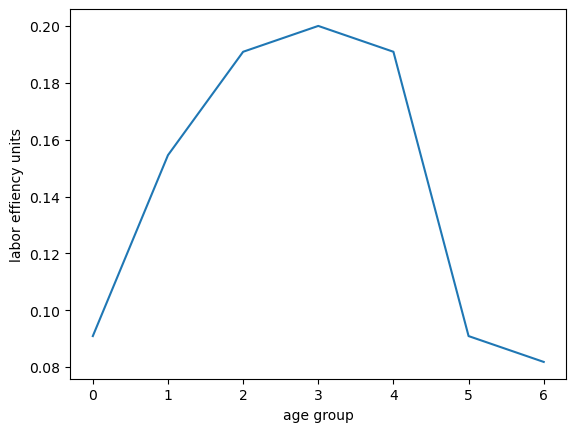

Pi =  [[0.63 0.07 0.27 0.03]
 [0.49 0.21 0.21 0.09]
 [0.18 0.02 0.72 0.08]
 [0.14 0.03 0.56 0.24]]
jnp.sum(Pi, axis = 1) =  [1.         1.         1.         0.96999997]


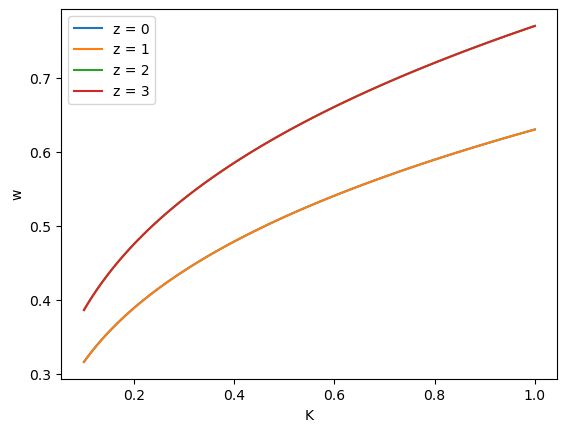

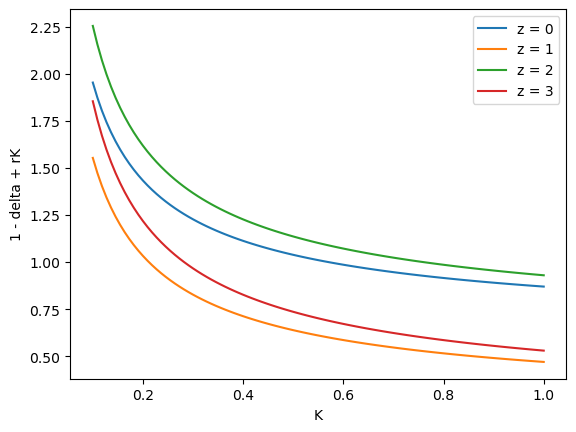

In [24]:
def utility(c):
    # we assume log utilitu
    return jnp.log(c)

def marg_utility(c):
    return 1. / c

def fischer_burmeister(a, b):
    return a + b - jnp.sqrt(a ** 2 + b ** 2)

beta = 0.7 # patience
alpha = 0.3 # capital share in production

# labor efficiency
l = jnp.array([1.0, 1.7, 2.1, 2.2, 2.1, 1.00, 0.90])
l = l / jnp.sum(l)
L = jnp.sum(l)

plt.plot(l)
plt.xlabel("age group")
plt.ylabel("labor effiency units")
plt.show()

# number of exogenous shocks
nZ = 4

# transition matrix
Pi = jnp.array(
    [
        [0.7 * 0.9, 0.7 * 0.1, 0.3 * 0.9, 0.3 * 0.1],
        [0.7 * 0.7, 0.7 * 0.3, 0.3 * 0.7, 0.3 * 0.3],
        [0.2 * 0.9, 0.2 * 0.1, 0.8 * 0.9, 0.8 * 0.1],
        [0.2 * 0.7, 0.3 * 0.1, 0.8 * 0.7, 0.8 * 0.3]        
    ]
)
print("Pi = ", Pi)
print("jnp.sum(Pi, axis = 1) = ", jnp.sum(Pi, axis = 1))

# productivity
Avec = jnp.array([0.9, 0.9, 1.1, 1.1])

# depreciation
deltavec = jnp.array([0.40, 0.80, 0.40, 0.80])

def get_return_wages(A, K, L, alpha):
    w = (1 - alpha) * A * K ** alpha * L ** (-alpha)
    rK = alpha * A * K ** (alpha - 1) * L ** (1 - alpha)

    return w, rK

for z in range(nZ):
    A = Avec[z]
    
    Kplot = np.linspace(0.1, 1.0, 100)

    w, _ = get_return_wages(A, Kplot, L, alpha)

    plt.plot(Kplot, w, label = "z = "+str(z))

plt.xlabel("K")
plt.ylabel("w")
plt.legend()
plt.show()


for z in range(nZ):
    A = Avec[z]
    delta = deltavec[z]
    
    Kplot = np.linspace(0.1, 1.0, 100)

    _, rK = get_return_wages(A, Kplot, L, alpha)

    plt.plot(Kplot, (1 - delta + rK), label = "z = "+str(z))

plt.xlabel("K")
plt.ylabel("1 - delta + rK")
plt.legend()
plt.show()



### Defining the neural network
We have a 8 dimensional input state (the shock $z_t$ together with the wealth distribution) and a 6 dimensional output (the savings for each age group except the last). We define a densely connected feedforward neural network with two hidden layers. We approximate the savingsrate of each household, i.e. what fraction of his total income (labor and capital) does the household save for the next period. In the output layer, we will use a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function, so the output is always between 0 and 1. 

In [25]:
# He initialization (suitable for ReLU activation)
def he_init(key, in_dim, out_dim):
    stddev = jnp.sqrt(2.0 / in_dim)
    return stddev * jax.random.normal(key, (out_dim, in_dim))

# Initialize parameters for deep NN
def init_params_deep(key, layer_sizes):
    params = {}
    keys = jax.random.split(key, len(layer_sizes)-1)
    for i in range(len(layer_sizes)-1):
        params[f'W{i+1}'] = he_init(keys[i], layer_sizes[i], layer_sizes[i+1])
        params[f'b{i+1}'] = jnp.zeros(layer_sizes[i+1])
    return params

key = jax.random.PRNGKey(0)

layer_sizes = [8, 200, 100, 6] # two hidden layers with 200 and 100 neurons

params_deep = init_params_deep(key, layer_sizes)
print("Deep NN parameters:")
for key, value in params_deep.items():
    print(f"{key}: {value.shape}")

@jax.jit
def nn(params, x):
    h = x
    num_layers = len(params) // 2
    for i in range(1, num_layers):
        h = jax.nn.relu(params[f'W{i}']@h + params[f'b{i}'])
    # Output layer
    # Use sigmoid activation because we approximate the savings rate which  is between 0 and 1
    output = jax.nn.sigmoid(params[f'W{num_layers}']@h + params[f'b{num_layers}'])
    return output

@jax.jit
def batch_nn(params, x_batch):
    vec_deep_nn = jax.vmap(nn, in_axes=(None, 0))
    return vec_deep_nn(params, x_batch)

Deep NN parameters:
W1: (200, 8)
b1: (200,)
W2: (100, 200)
b2: (100,)
W3: (6, 100)
b3: (6,)


### Defining the loss function
As a loss function we want to have the error in the equilibrium conditions, which are the 6 first order conditions of the households. The first order conditions involve expectations over the next period, so we will have to iterate over possible shocks in the next period to evaluate the expectation. We first implement a function that implements the errors in the first order condition for each age group implied by a state $\mathbf{x}$ and by the neural network.

In [26]:
@jax.jit
def eulererrors(x, params):
    # read out the state
    z = x[0].astype(int) # exogenous shock, convert to integer
    kdist = x[1 : 8] # distribution of capital

    # get aggregate capital
    K = jnp.sum(kdist)

    # get productivity and depreciation
    A = Avec[z]
    delta = deltavec[z]

    # get return on capital and wages
    w, rK = get_return_wages(A, K, L, alpha)

    # get savings policies
    savingsrate = nn(params, x)

    # append a 0 in the end, because the last age group saves nothing
    savingsrate = jnp.append(savingsrate, 0)

    # get total cash
    cash = (1 - delta + rK) * kdist + w * l
    
    # get savings policies
    ksav = savingsrate * cash

    # get consumption
    c = cash - ksav

    # get marginal utility
    mu = marg_utility(c)

    # now we already have the LHS of the Euler equation
    LHS = mu[0 : 6] # the last age group does not have an Euler equation

    # get the RHS of the Euler equation
    RHS  = jnp.zeros(6)
    # we need to loop over the shocks in the next period and compute the expectation
    for znext in range(nZ):
        # get the transition probability
        prob = Pi[z, znext]
        
        # get state in the next period
        knext = jnp.concat([jnp.array([0]), ksav[0 : 6]]) # capital in the beginning of next period by age group
        
        # get aggregate capital in the next period
        Knext = jnp.sum(knext)
        
        # get productivity and depreciation
        Anext = Avec[znext]
        deltanext = deltavec[znext]
        
        # get return on capital and wages
        wnext, rKnext = get_return_wages(Anext, Knext, L, alpha)

        # get state in the next period
        xnext = jnp.concat([jnp.array([znext]), knext])
        # get the savings policies
        savingsratenext = nn(params, xnext)
        
        # append a 0 in the end, because the last age group saves nothing
        savingsratenext = jnp.append(savingsratenext, 0)

        # get total cash
        cashnext = (1 - deltanext + rKnext) * knext + wnext * l
        # get savings policies
        ksavnext = savingsratenext * cashnext

        # get consumption
        cnext = cashnext - ksavnext
        # make sure consumption is positive
        cnext = jnp.maximum(cnext, 1e-8)

        # get marginal utility
        munext = marg_utility(cnext)
        
        # get the RHS of the Euler equation
        RHS += prob * beta * munext[1 : 7] * (1 - deltanext + rKnext)

    # get the euler error for each age group
    eulererror = fischer_burmeister((LHS - RHS) / LHS, (ksav/c)[0 : 6])

    # return the euler error
    return eulererror, c, cnext, savingsrate

# get a batched version of the Euler eulererrors
def batch_eulererrors(x_batch, params):
    vec_eulererrors = jax.jit(jax.vmap(eulererrors, in_axes=(0, None)))
    return vec_eulererrors(x_batch, params)

In [27]:
xtest = jnp.array([3., 0., 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])
print("xtest = ", xtest)
print("eulererrors(xtest, params_deep) = ", eulererrors(xtest, params_deep))

xtest =  [3.  0.  0.3 0.3 0.3 0.3 0.3 0.3]
eulererrors(xtest, params_deep) =  (Array([ 0.63772035, -1.8866622 ,  0.93689346, -2.4718916 ,  0.47108018,
        0.2848035 ], dtype=float32), Array([0.02861647, 0.11364798, 0.017097  , 0.25015506, 0.10377038,
       0.12961143, 0.20075497], dtype=float32), Array([0.02306352, 0.07583449, 0.01074401, 0.25584933, 0.04613551,
       0.11466493, 0.10536689], dtype=float32), Array([0.6572825 , 0.5752334 , 0.9431906 , 0.19123057, 0.6551946 ,
       0.3801606 , 0.        ], dtype=float32))


In [28]:
batch_xtest = jnp.array([
    [3., 0., 1., 1., 1., 1., 1, 1.],
    [2., 0., 1., 1., 1., 1., 1, 1.],
    [0., 0., 1., 1., 1., 1., 1, 1.],
    [1., 0., 1., 1., 1., 1., 1, 1.],
    [4., 0., 1., 1., 1., 1., 1, 1.]
    ])
print("batch_xtest = ", batch_xtest)

print("batch_eulererrors(batch_xtest, params_deep) = ", batch_eulererrors(batch_xtest, params_deep))

batch_xtest =  [[3. 0. 1. 1. 1. 1. 1. 1.]
 [2. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1.]
 [4. 0. 1. 1. 1. 1. 1. 1.]]
batch_eulererrors(batch_xtest, params_deep) =  (Array([[ 0.51642776, -0.46239638,  0.9159088 , -5.795079  ,  0.3018806 ,
         0.39084208],
       [ 0.49701166, -0.02994752,  0.77279806, -6.3678856 ,  0.27496064,
         0.50829613],
       [ 0.30650026,  0.4581523 ,  0.11135674, -3.352232  ,  0.7812357 ,
         0.5132065 ],
       [ 0.39002538,  0.35833645,  0.49991643, -2.1502419 ,  0.59569097,
         0.5878426 ],
       [ 0.602026  , -0.57914734,  0.9638767 , -7.1088166 ,  0.33506906,
         0.25995302]], dtype=float32), Array([[0.05526915, 0.13974085, 0.04096353, 0.4952557 , 0.21659076,
        0.21140255, 0.40198883],
       [0.0596967 , 0.2205391 , 0.17702198, 0.79131746, 0.3268956 ,
        0.3206632 , 0.80198884],
       [0.06466119, 0.16054958, 0.51106924, 0.6468654 , 0.09172326,
        0.3011139 , 0.7652636 ],
      

As loss function we implement the mean squared error in the first order conditions.

In [29]:
@jax.jit
def loss(xbatch, params):
    # get the euler errors
    eulererror, c, cnext, savingsrate = batch_eulererrors(xbatch, params)
    # get the sum of squares of the euler errors
    loss = jnp.mean(eulererror ** 2)
    return loss

In [30]:
print("loss(batch_xtest, params_deep) = ", loss(batch_xtest, params_deep))

loss(batch_xtest, params_deep) =  4.916637


### Defining the parameter update
We update the parameters with (a variant of) gradient descent.

In [31]:
def update(params, optimizer, opt_state, x_batch):
    # compute gradients
    grads = jax.grad(loss, argnums=1)(x_batch, params)
    # compute the parameter updates
    updates, opt_state = optimizer.update(grads, opt_state)
    # apply the updates to the parameters
    params = optax.apply_updates(params, updates)
    return params, opt_state

### Sampling the most important states
Which states $\mathbf{x}$ should we sample to train the neural network on? That depends on the policy! This is because the states that are relevant to us are the ones that can be reached when we simulate the model. So we jointly have to find the policies together with the set of states that the policy generates. To do this we can get new training data by simulating the model on step forward.

In [32]:
@jax.jit
def sample_new_shock(key, z):
    # sample a new shock from the transition matrix
    znext = jax.random.choice(key, jnp.arange(nZ), p = Pi[z, :])
    return znext

@jax.jit
def sample_new_shock_batch(batch_key, batch_z):
    znext = jax.vmap(sample_new_shock, in_axes=(0, 0))(batch_key, batch_z)
    # reshape the output
    znext = jnp.reshape(znext, (-1,1))
    return znext

In [33]:
@jax.jit
def get_new_states(x_batch, params, random_key):
    num_states = x_batch.shape[0]

    # read out the state
    z = x_batch[:, 0].astype(int)
    kdist = x_batch[:, 1 : 8]
    # get aggregate capital
    K = jnp.sum(kdist, axis = 1)

    # get productivity and depreciation
    A = Avec[z]
    delta = deltavec[z]
    
    # get return on capital and wages
    w, rK = get_return_wages(A, K, L, alpha)

    # get savings policies
    savingsrate = batch_nn(params, x_batch)

    # append a 0 in the end, because the last age group saves nothing
    savingsrate = jnp.append(savingsrate, jnp.zeros([num_states, 1]), axis = 1)

    # get total cash
    cash = (1 - delta[:, jnp.newaxis] + rK[:, jnp.newaxis]) * kdist + w[:, jnp.newaxis] * l[jnp.newaxis, :]
    
    # get savings policies
    ksav = savingsrate * cash

    # get the distribution of capital in the beginning of the next period
    knext = jnp.concat([jnp.zeros((num_states, 1)), ksav[:, 0 : 6]], axis = 1) # capital in the beginning of next period by age group

    # sample random exogenous shocks
    batch_random_key = jax.random.split(random_key, num_states + 1)
    batch_random_key = batch_random_key[1:]
    random_key = batch_random_key[0]

    znext = sample_new_shock_batch(batch_random_key, z)

    # get the new states
    xnew_batch = jnp.concat([znext, knext], axis = 1)

    return xnew_batch, random_key

In [34]:
random_key = jax.random.PRNGKey(7)

xbatch_new, key_new = get_new_states(batch_xtest, params_deep, random_key)
print("xbatch_new = ", xbatch_new)

xbatch_new =  [[2.         0.         0.06455474 0.35810712 0.50481397 0.06250417
  0.32918674 0.2025687 ]
 [2.         0.         0.06012719 0.67730886 0.76875556 0.16644248
  0.61888194 0.493308  ]
 [0.         0.         0.03337655 0.6831442  0.37183964 0.2458473
  0.7911856  0.4739535 ]
 [0.         0.         0.04169524 0.34286937 0.29885113 0.11602112
  0.3726239  0.2433876 ]
 [2.         0.         0.07422322 0.35142002 0.5278798  0.04623512
  0.338905   0.16266514]]


### The training loop


In [35]:
# Define the optimizer
optimizer = optax.adam(learning_rate=0.0001)

# Initialize the optimizer state
opt_state = optimizer.init(params_deep)


In [36]:
batch_size = 1024

num_simulation_steps = 5000

# initial state
xbatch_old = 0.05 * jnp.ones((batch_size, 8))


Step 0, Loss: 0.31359967589378357


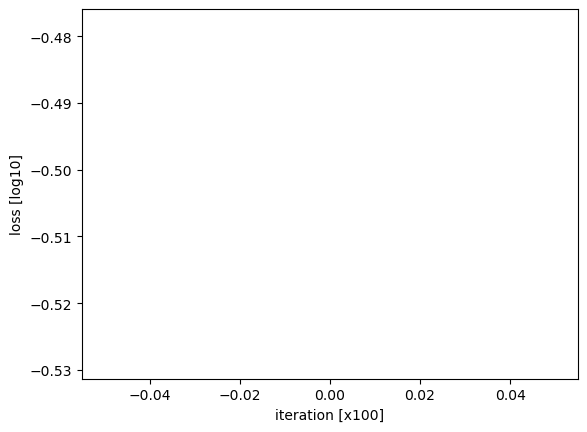

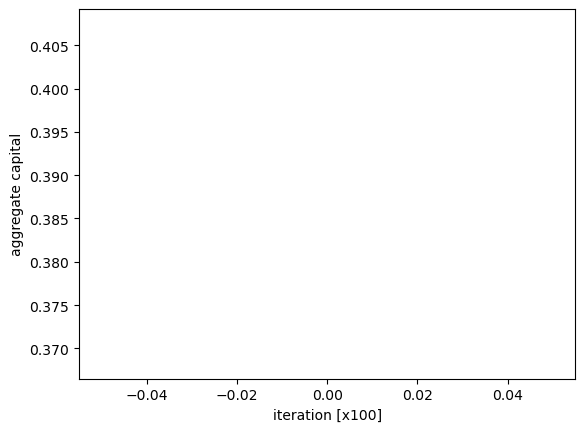

Step 100, Loss: 0.09886165708303452
Step 200, Loss: 0.05508580803871155
Step 300, Loss: 0.028335152193903923
Step 400, Loss: 0.017745867371559143
Step 500, Loss: 0.010529983788728714


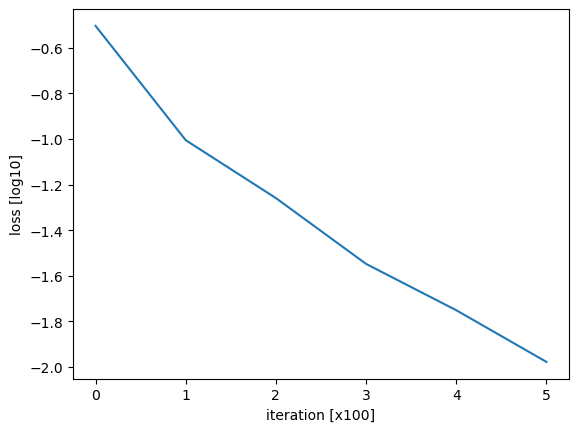

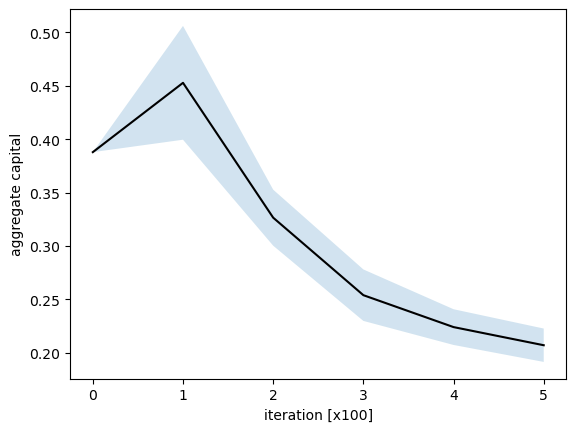

Step 600, Loss: 0.007387099787592888
Step 700, Loss: 0.00483253039419651
Step 800, Loss: 0.0039033545181155205
Step 900, Loss: 0.0029941562097519636
Step 1000, Loss: 0.0023409794084727764


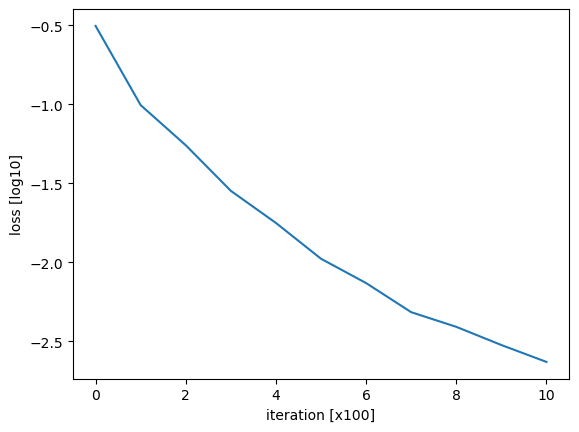

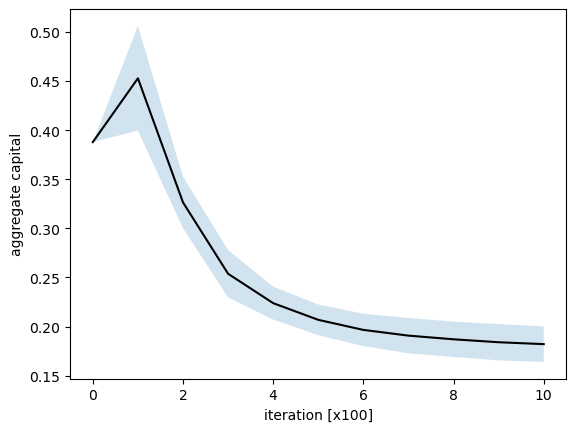

Step 1100, Loss: 0.0017468263395130634
Step 1200, Loss: 0.0014946683077141643
Step 1300, Loss: 0.0011941035045310855
Step 1400, Loss: 0.0009959805756807327
Step 1500, Loss: 0.0009592818096280098


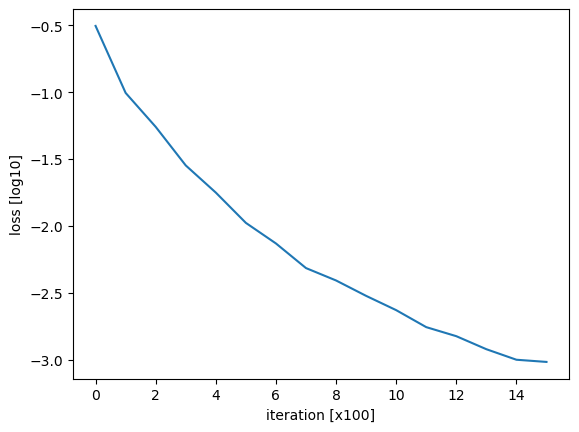

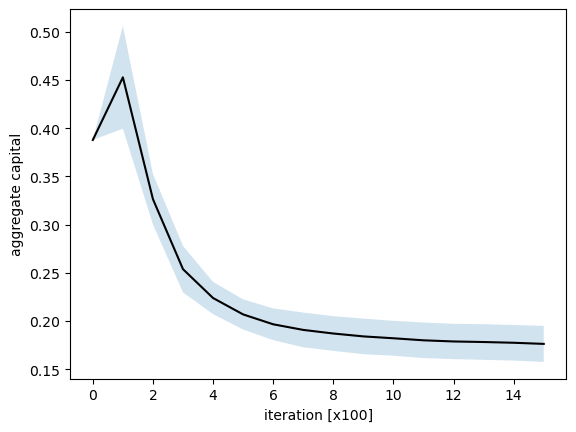

Step 1600, Loss: 0.0008326413808390498
Step 1700, Loss: 0.0007822220213711262
Step 1800, Loss: 0.0007476279279217124
Step 1900, Loss: 0.000720989890396595
Step 2000, Loss: 0.0006396481767296791


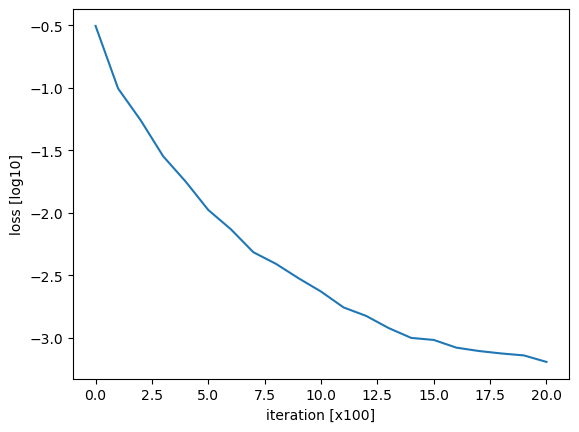

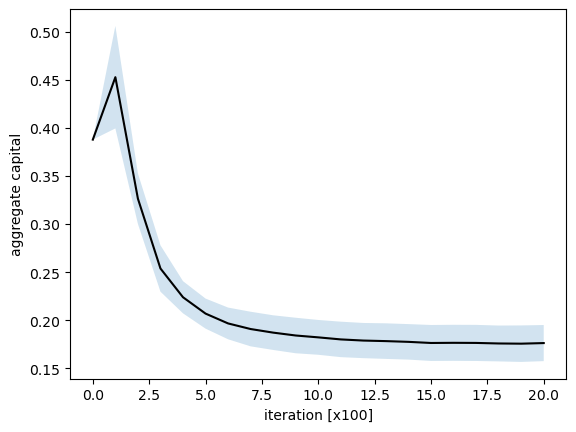

Step 2100, Loss: 0.0006572201382368803
Step 2200, Loss: 0.0005532966461032629
Step 2300, Loss: 0.00051715481095016
Step 2400, Loss: 0.00048751881695352495
Step 2500, Loss: 0.0004330533556640148


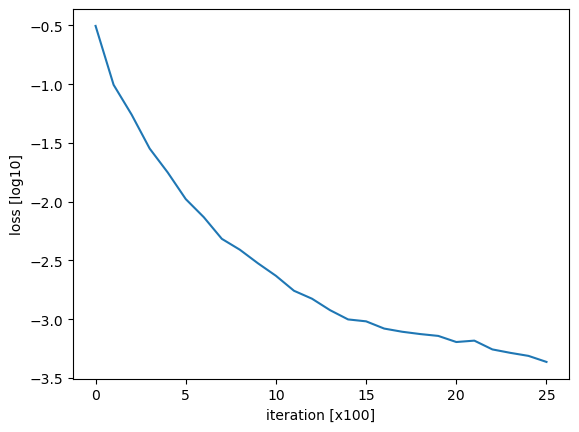

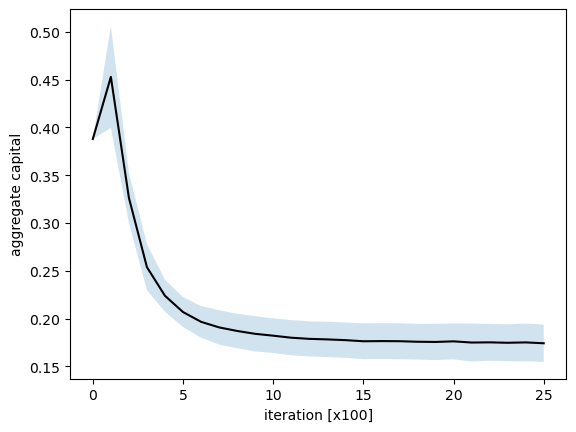

Step 2600, Loss: 0.0004037863982375711
Step 2700, Loss: 0.0003692916361615062
Step 2800, Loss: 0.00034616823541000485
Step 2900, Loss: 0.0003282091929577291
Step 3000, Loss: 0.0002789995342027396


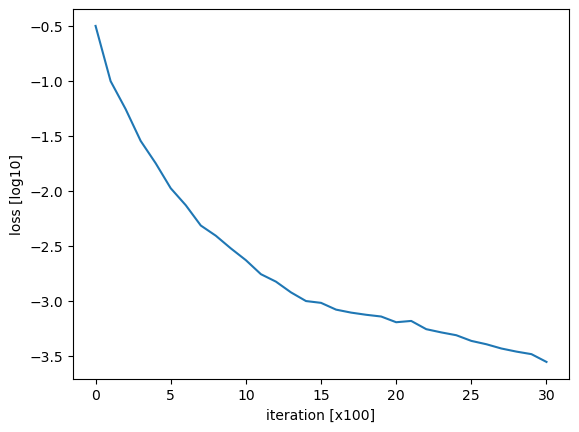

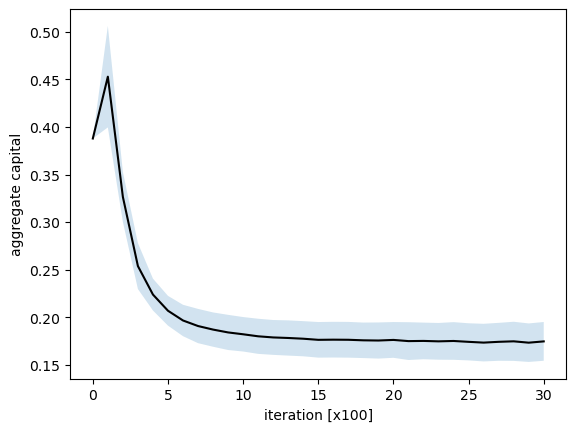

Step 3100, Loss: 0.0002528002951294184
Step 3200, Loss: 0.00023848548880778253
Step 3300, Loss: 0.00021100549201946706
Step 3400, Loss: 0.00018756002828013152
Step 3500, Loss: 0.00015933629765640944


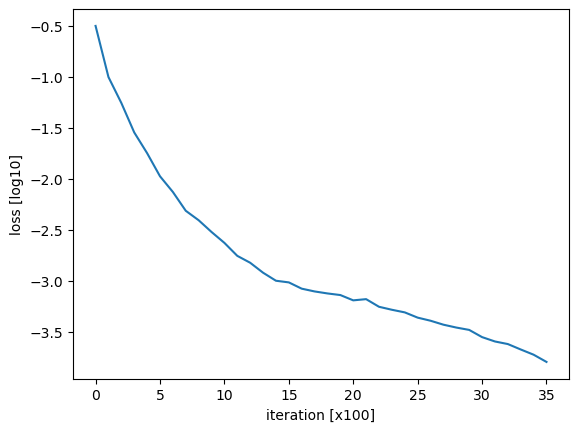

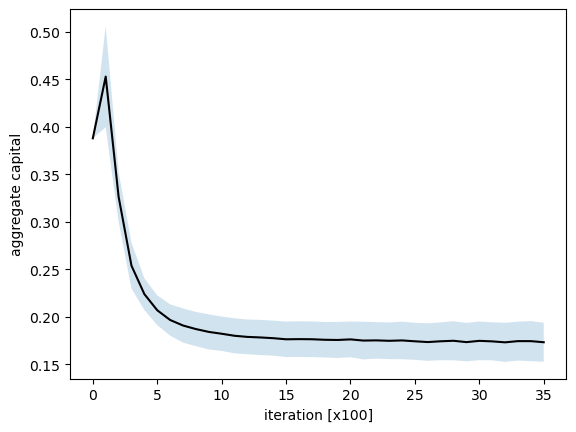

Step 3600, Loss: 0.00013379949086811393
Step 3700, Loss: 0.00011606239422690123
Step 3800, Loss: 0.00010484975064173341
Step 3900, Loss: 9.589716501068324e-05
Step 4000, Loss: 8.26518953545019e-05


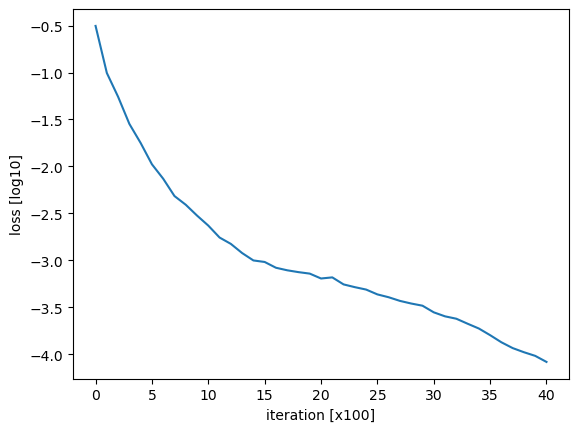

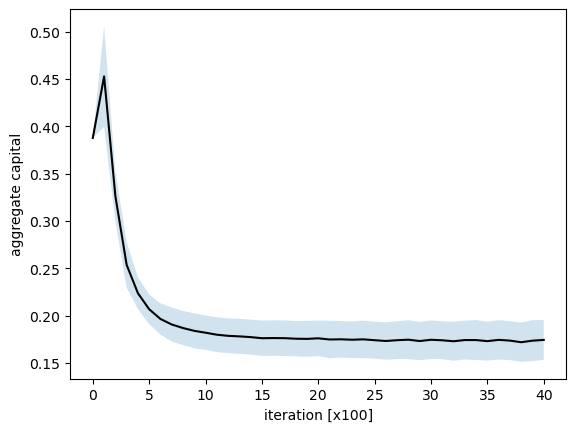

Step 4100, Loss: 7.720082066953182e-05
Step 4200, Loss: 7.406718214042485e-05
Step 4300, Loss: 6.221260264283046e-05
Step 4400, Loss: 6.189829582581297e-05
Step 4500, Loss: 5.901028634980321e-05


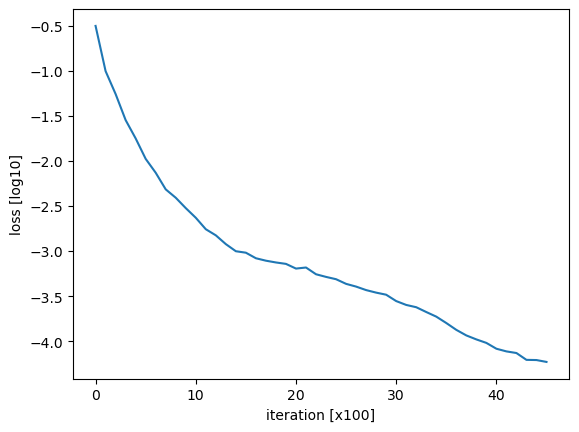

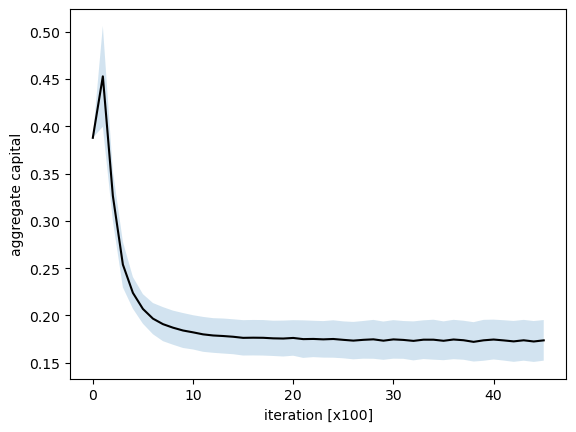

Step 4600, Loss: 5.1901322876801714e-05
Step 4700, Loss: 4.995043855160475e-05
Step 4800, Loss: 4.504760727286339e-05
Step 4900, Loss: 4.4727516069542617e-05


In [37]:
loss_list = []
mean_agg_K_list = []
std_agg_K_list = []

for step in range(num_simulation_steps):
    xbatch_new, random_key = get_new_states(xbatch_old, params_deep, random_key)

    # update the parameters
    params_deep, opt_state = update(params_deep, optimizer, opt_state, xbatch_new)

    # print the loss
    if step % 100 == 0:
        loss_value = loss(xbatch_new, params_deep)
        loss_list.append(loss_value)

        mean_agg_K = jnp.mean(jnp.sum(xbatch_new[:, 1 : 8], axis = 1))
        std_agg_K = jnp.std(jnp.sum(xbatch_new[:, 1 : 8], axis = 1))
        
        mean_agg_K_list.append(mean_agg_K)
        std_agg_K_list.append(std_agg_K)

        print(f"Step {step}, Loss: {loss_value}")
        if step%500 == 0:
            plt.plot(np.log10(np.array(loss_list)))
            plt.xlabel("iteration [x100]")
            plt.ylabel("loss [log10]")
            plt.show()

            plt.plot(mean_agg_K_list, "k-")
            plt.fill_between(range(len(mean_agg_K_list)), np.array(mean_agg_K_list) - np.array(std_agg_K_list), np.array(mean_agg_K_list) + np.array(std_agg_K_list), alpha=0.2)
            plt.xlabel("iteration [x100]")
            plt.ylabel("aggregate capital")
            plt.show()
    xbatch_old = xbatch_new
        


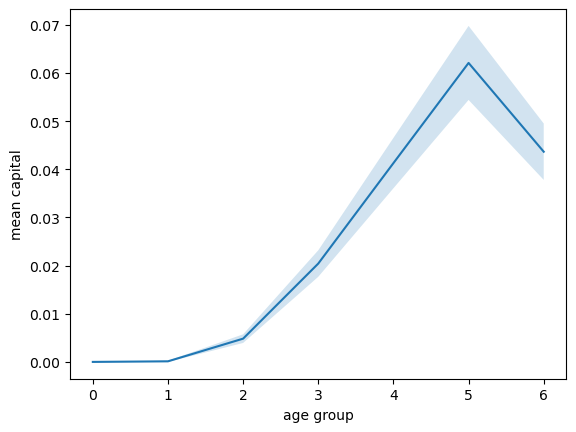

In [38]:
mean_k_age = jnp.mean(xbatch_new[:, 1 : 8], axis = 0)
std_k_age = jnp.std(xbatch_new[:, 1 : 8], axis = 0)
plt.plot(mean_k_age)
plt.fill_between(range(len(mean_k_age)), mean_k_age - std_k_age, mean_k_age + std_k_age, alpha=0.2)
plt.xlabel("age group")
plt.ylabel("mean capital")
plt.show()

In [39]:
eulererror, c, cnext, savingsrate = batch_eulererrors(xbatch_new, params_deep)

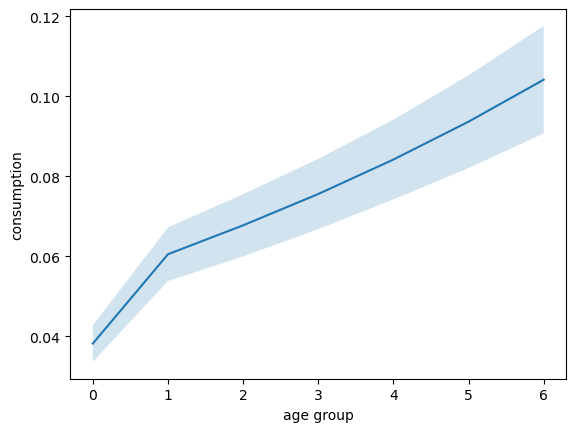

In [40]:
mean_c_age = jnp.mean(c, axis = 0)
std_c_age = jnp.std(c, axis = 0)

plt.plot(mean_c_age)
plt.fill_between(range(len(mean_c_age)), mean_c_age - std_c_age, mean_c_age + std_c_age, alpha=0.2)
plt.xlabel("age group")
plt.ylabel("consumption")
plt.show()


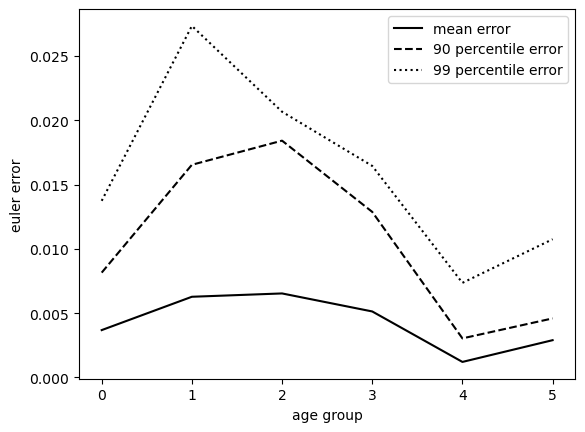

In [41]:
plt.plot(jnp.mean(jnp.abs(eulererror[:, :]), axis = 0), "k-", label = "mean error")
plt.plot(jnp.percentile(jnp.abs(eulererror[:, :]), 90, axis = 0), "k--", label = "90 percentile error")
plt.plot(jnp.percentile(jnp.abs(eulererror[:, :]), 99, axis = 0), "k:", label = "99 percentile error")
plt.legend()
plt.xlabel("age group")
plt.ylabel("euler error")
plt.show()